In [1]:
%load_ext autoreload
%autoreload 2

In [205]:
import numpy as np
import builtins
import keras
import tensorflow as tf
#from keras import backend as K
from extra_keras_metrics import average_precision_at_k
from IPython.display import SVG
from keras.utils.vis_utils import plot_model
import pydot as pyd
from keras.utils.vis_utils import model_to_dot
#from keras.layers import Input, Dense, Embedding, Lambda, Reshape, Flatten, Average
#from keras.models import Model
#from keras.backend import mean, max
#from keras.preprocessing.sequence import pad_sequences

keras.utils.vis_utils.pydot = pyd

In [206]:
import random

In [207]:
import sys
sys.path.append('..')

In [208]:
from data_loader import data_generator

In [209]:
tf.__version__

'1.13.1'

In [210]:
tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [243]:
class RecoDNN():
    
    def __init__(self, max_transaction_history = 50, max_product_click_history = 50, max_promotion_click_history = 50,
                 category_size = 100, single_categorical_features = None, numeric_features_size = 10,
                 hidden_layer1_size = 256, hidden_layer2_size = 64, hidden_layer3_size = 16, activation='relu',
                input_embedding_size = 128):
        
        self.max_transaction_history = max_transaction_history
        self.max_product_click_history = max_product_click_history
        self.max_promotion_click_history = max_promotion_click_history
        self.category_size = category_size
        self.hidden_layer1_size = hidden_layer1_size
        self.hidden_layer2_size = hidden_layer2_size
        self.hidden_layer3_size = hidden_layer3_size
        self.single_categorical_features = single_categorical_features
        self.numeric_features_size = numeric_features_size
        self.activation = activation
        self.input_embedding_size = input_embedding_size
        
        self.category_embeddings = tf.keras.layers.Embedding(output_dim=self.input_embedding_size, 
                                                             input_dim = self.category_size, mask_zero=True, name='category_embeddings')
        
        self.build()
        
    
    def build(self):
        
        inp_layer, inp_embed = self.create_input()
        
        v = tf.keras.layers.Dense(self.hidden_layer1_size, activation = self.activation)(tf.keras.layers.concatenate(inp_embed)) 
        v = tf.keras.layers.Dense(self.hidden_layer2_size, activation = self.activation)(v)
        v = tf.keras.layers.Dense(self.hidden_layer3_size, activation = self.activation, name='user_embedding')(v)
        output = tf.keras.layers.Dense(self.category_size, activation ='softmax', name='softmax_layer')(v)
        self.model = tf.keras.models.Model(inputs = inp_layer, outputs = [output])    
        
    
    def create_input(self):
        
        transaction_cols = [x for x in range(self.max_transaction_history)]
        product_click_cols = [x for x in range(self.max_product_click_history)]
        promotion_click_cols = [x for x in range(self.max_promotion_click_history)]
        seq_category_cols = [transaction_cols, product_click_cols, promotion_click_cols]
        
        seqs = []
        for i, grp in enumerate(seq_category_cols):
            seqs.append(self.seq_categorical_input('seq_categorical_' + str(i), len(grp)))

        singles = []
        if self.single_categorical_features:
            for col in self.single_categorical_features:
                singles.append(self.singe_categorical_input(str(col), self.single_categorical_features[col][0], 
                                                           self.single_categorical_features[col][1]))

        nums = self.continous_inputs(self.numeric_features_size)

        inp_layer =  [s[0] for s in seqs]
        inp_layer += [s[0] for s in singles]
        inp_layer.append(nums[0])
        inp_embed = [s[1] for s in seqs]
        inp_embed += [s[1] for s in singles]
        inp_embed.append(nums[1])
               
        return inp_layer, inp_embed
    
    
    def seq_categorical_input(self, name, max_history):
    
        seq = tf.keras.layers.Input(shape=(max_history,), dtype='int32', name=name)
        category_embeddings = tf.keras.layers.Embedding(output_dim=self.input_embedding_size,input_dim = self.category_size, name=name+'category_embeddings')
        input_embeddings = category_embeddings(seq)
        #avg = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1), name= name + '_avg_embedding')
        #avg_embedding = tf.reduce_mean(input_embeddings, axis=0), name= name + '_avg_embedding'))
        #avg_embedding = tf.keras.layers.GlobalAveragePooling1D(name=name + '_avg_embedding')(input_embeddings, mask=self.category_embeddings.compute_mask(seq))
        #cat_embeddings = tf.reshape(input_embeddings, [, -1])

        #maxf = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=1), name = name + '_max_embedding')
        #max_embedding = maxf(input_embeddings)

        return seq, tf.keras.layers.Flatten(name = 'flatten_' + name)(input_embeddings)   #keras.layers.add([avg_embedding, max_embedding])
        #return seq, tf.keras.layers.concatenate([avg_embedding, max_embedding])

    
    def singe_categorical_input(self, name, unique_size, embedding_size):
        single = tf.keras.layers.Input(shape=(1,), dtype='int32', name=name)
        embeddings = tf.keras.layers.Embedding(output_dim = embedding_size, input_dim = unique_size, 
                           input_length=1, name=name + '_embedding')(single)
        embeddings = tf.keras.layers.Flatten(name = 'flatten_' + name)(embeddings)
        return single, embeddings
    
    def continous_inputs(self, size=None, name='numeric'):
        inp = tf.keras.layers.Input(shape=(size,), dtype='float32', name=name)
        return inp, inp


# fake dataset

In [228]:
data_size = 500
max_transaction_history = 50
max_product_click_history = 50
max_promotion_click_history = 50
input_embedding_size = 16
category_size = 10
numeric_size = 10

data1 = np.random.randint(category_size, size=(data_size, random.randint(1,max_transaction_history)))
data1 = tf.keras.preprocessing.sequence.pad_sequences(data1, 50, padding='post')
#data1 = np.array([[1,2], [1,2,4]])

data2 = np.random.randint(category_size, size=(data_size, max_product_click_history-3))
data2 = tf.keras.preprocessing.sequence.pad_sequences(data2, 50, padding='post')

data3 = np.random.randint(category_size, size=(data_size, max_promotion_click_history-4))
data3 = tf.keras.preprocessing.sequence.pad_sequences(data3, 50, padding='post')

inputs = [data1, data2, data3]

single_category_cols = {105:(3,8),106:(5,8),107:(10,8)}   ## such as location : unique_value_size
for k in single_category_cols:
    inputs.append(np.random.randint(single_category_cols[k][0], size=(data_size, 1)))

num1 = np.random.random(size=(data_size, numeric_size))
inputs.append(num1)

labels = np.random.randint(category_size, size=(data_size, 1))
one_hot_labels = keras.utils.to_categorical(labels, num_classes=category_size)


In [229]:
data1

array([[9, 1, 1, ..., 0, 0, 0],
       [6, 2, 9, ..., 0, 0, 0],
       [9, 6, 8, ..., 0, 0, 0],
       ...,
       [3, 7, 6, ..., 0, 0, 0],
       [6, 6, 8, ..., 0, 0, 0],
       [8, 7, 1, ..., 0, 0, 0]], dtype=int32)

## save locally

In [215]:
#inputs1 = inputs.copy()
#inputs1.append(labels)
#merge = np.hstack(inputs1)
#np.savetxt('../data/features.csv', merge, fmt="%2.3f")

# test tfrecord inputs

## save tfrecord file for test

In [230]:

output_filename = "../data/tf.tfrecord"

def float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list(value)))

with tf.python_io.TFRecordWriter(output_filename) as writer:
    for (v1,v2,v3,v4,v5,v6,v7,v8) in zip(data1, data2, data3, inputs[3], inputs[4], inputs[5], inputs[6], labels):
        features = {'seq_categorical_0': int64_feature(v1), 'seq_categorical_1': int64_feature(v2),
                    'seq_categorical_2': int64_feature(v3),'105': int64_feature(v4),
                    '106': int64_feature(v5),'107': int64_feature(v6), 'numeric': float_feature(v7),
                    'labels': float_feature(v8)}
        tf_example = tf.train.Example(features=tf.train.Features(feature=features))
        writer.write(tf_example.SerializeToString())



## load tfrecord file

In [231]:
def parse_function(example_proto):
    features = {"seq_categorical_0":tf.FixedLenFeature([50],tf.int64),
                "seq_categorical_1":tf.FixedLenFeature([50], tf.int64),
                "seq_categorical_2":tf.FixedLenFeature([50], tf.int64),
                "105":tf.FixedLenFeature([1], tf.int64),
                "106":tf.FixedLenFeature([1], tf.int64),
                "107":tf.FixedLenFeature([1], tf.int64),
                "numeric":tf.FixedLenFeature([10], tf.float32),
                "labels":tf.FixedLenFeature([1], tf.float32),
         }
    parsed_features = tf.parse_single_example(example_proto, features)
    #return parsed_features
    return (parsed_features["seq_categorical_0"], parsed_features["seq_categorical_1"], parsed_features["seq_categorical_2"], parsed_features["105"], parsed_features["106"], parsed_features["107"], parsed_features["numeric"]), parsed_features["labels"]

In [232]:
#debug generated tfrecord
try:
    for i, str_rec in enumerate(tf.python_io.tf_record_iterator("../data/tf.tfrecord")):
        example = tf.train.Example()
        example.ParseFromString(str_rec)
        #print(i, dict(example.features.feature).keys())
except:
    print(i)

In [272]:
def load_data():
    ds=tf.data.TFRecordDataset('../data/tf.tfrecord')
    ds=ds.map(parse_function, num_parallel_calls=4)
    ds=ds.repeat()  # Repeat the input indefinitely.
    ds=ds.batch(32)
    iterator = ds.make_one_shot_iterator()
    features, labels = iterator.get_next()
 
    return features, labels

In [250]:
ds3=tf.data.TFRecordDataset('../data/tf.tfrecord')

In [251]:
ds3=ds3.map(parse_function, num_parallel_calls=4)

In [252]:
ds3 = ds3.repeat()  # Repeat the input indefinitely.
ds3 = ds3.batch(32)
#iterator = ds3.make_initializable_iterator()

In [253]:
ds3.output_shapes

((TensorShape([Dimension(None), Dimension(50)]),
  TensorShape([Dimension(None), Dimension(50)]),
  TensorShape([Dimension(None), Dimension(50)]),
  TensorShape([Dimension(None), Dimension(1)]),
  TensorShape([Dimension(None), Dimension(1)]),
  TensorShape([Dimension(None), Dimension(1)]),
  TensorShape([Dimension(None), Dimension(10)])),
 TensorShape([Dimension(None), Dimension(1)]))

# test dataset from ndarray

In [296]:
ds2=tf.data.Dataset.from_tensor_slices(
    ({'seq_categorical_0': data1, 'seq_categorical_1': data2, 'seq_categorical_2': data3, 
     '105': inputs[3], '106': inputs[4],'107': inputs[5],'numeric': inputs[6]},
     {'softmax_layer': one_hot_labels}))


In [297]:
ds2=ds2.repeat()
ds2=ds2.batch(32)

In [ ]:
ds2 = ds2.shuffle(buffer_size=1024).batch(64)

In [41]:
input_dataset = tf.data.Dataset.from_tensor_slices((data1, data2, data3, inputs[3], inputs[4], inputs[5], num1))

In [42]:
input_dataset.output_shapes

(TensorShape([Dimension(50)]),
 TensorShape([Dimension(50)]),
 TensorShape([Dimension(50)]),
 TensorShape([Dimension(1)]),
 TensorShape([Dimension(1)]),
 TensorShape([Dimension(1)]),
 TensorShape([Dimension(10)]))

In [38]:
output_dataset = tf.data.Dataset.from_tensor_slices((labels))

In [39]:
output_dataset.output_shapes

TensorShape([Dimension(1)])

In [43]:
input_dataset = input_dataset.batch(32).repeat()
output_dataset = output_dataset.batch(32).repeat()

In [44]:
dataset = tf.data.Dataset.zip((input_dataset, output_dataset))

In [45]:
dataset.output_shapes

((TensorShape([Dimension(None), Dimension(50)]),
  TensorShape([Dimension(None), Dimension(50)]),
  TensorShape([Dimension(None), Dimension(50)]),
  TensorShape([Dimension(None), Dimension(1)]),
  TensorShape([Dimension(None), Dimension(1)]),
  TensorShape([Dimension(None), Dimension(1)]),
  TensorShape([Dimension(None), Dimension(10)])),
 TensorShape([Dimension(None), Dimension(1)]))

# Training

In [261]:
model = RecoDNN(50,50, 50, category_size,
                numeric_features_size = numeric_size, input_embedding_size = input_embedding_size,
                single_categorical_features = single_category_cols).model

In [262]:
model.compile(loss='sparse_categorical_crossentropy',
                       optimizer='adam',
                       metrics=['sparse_categorical_accuracy'])

In [ ]:
model.summary()

In [ ]:
model_est=tf.keras.estimator.model_to_estimator(keras_model=model, model_dir="kkt")

In [278]:
train_input = lambda:load_data()

In [279]:
train_input()

((<tf.Tensor 'IteratorGetNext_4:0' shape=(?, 50) dtype=int64>,
  <tf.Tensor 'IteratorGetNext_4:1' shape=(?, 50) dtype=int64>,
  <tf.Tensor 'IteratorGetNext_4:2' shape=(?, 50) dtype=int64>,
  <tf.Tensor 'IteratorGetNext_4:3' shape=(?, 1) dtype=int64>,
  <tf.Tensor 'IteratorGetNext_4:4' shape=(?, 1) dtype=int64>,
  <tf.Tensor 'IteratorGetNext_4:5' shape=(?, 1) dtype=int64>,
  <tf.Tensor 'IteratorGetNext_4:6' shape=(?, 10) dtype=float32>),
 <tf.Tensor 'IteratorGetNext_4:7' shape=(?, 1) dtype=float32>)

In [ ]:
model_est.train(input_fn=train_input, steps=100)

In [191]:
plot_model(model, to_file='../figures/model.png', show_shapes=True, show_layer_names=True)

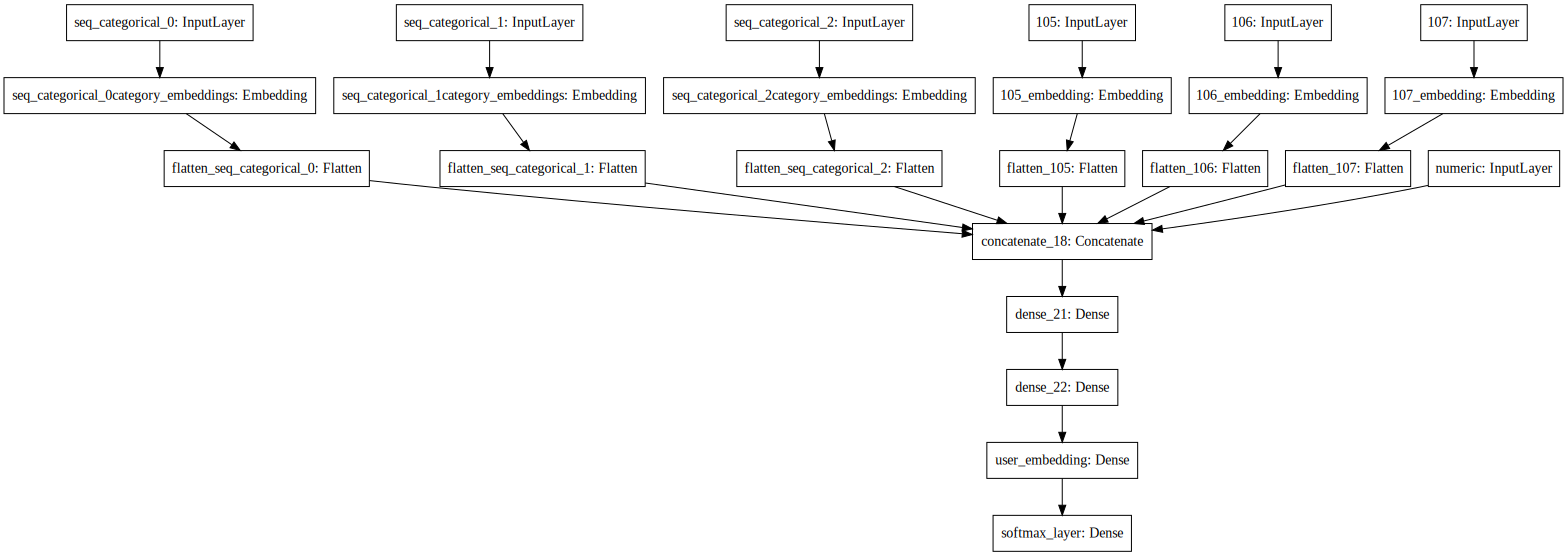

In [192]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [193]:
%time model.fit(x=inputs, y=labels, epochs=10, batch_size=32)

Epoch 1/10
500/500 [==============================] - 0s 788us/sample - loss: 2.3083 - sparse_categorical_accuracy: 0.0880
Epoch 2/10
500/500 [==============================] - 0s 242us/sample - loss: 2.2780 - sparse_categorical_accuracy: 0.1800
Epoch 3/10
500/500 [==============================] - 0s 233us/sample - loss: 2.2018 - sparse_categorical_accuracy: 0.3140
Epoch 4/10
500/500 [==============================] - 0s 229us/sample - loss: 1.9722 - sparse_categorical_accuracy: 0.4260
Epoch 5/10
500/500 [==============================] - 0s 220us/sample - loss: 1.5302 - sparse_categorical_accuracy: 0.5200
Epoch 6/10
500/500 [==============================] - 0s 221us/sample - loss: 0.9851 - sparse_categorical_accuracy: 0.7240
Epoch 7/10
500/500 [==============================] - 0s 235us/sample - loss: 0.5536 - sparse_categorical_accuracy: 0.9000
Epoch 8/10
500/500 [==============================] - 0s 221us/sample - loss: 0.2633 - sparse_categorical_accuracy: 0.9680
Epoch 9/10
500/5

In [194]:
layer_name = 'user_embedding'
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)


In [202]:
sz=3
dat = inputs[0][0:sz], inputs[1][0:sz],inputs[2][0:sz],inputs[3][0:sz],inputs[4][0:sz],inputs[5][0:sz],inputs[6][0:sz]

In [203]:
intermediate_output = intermediate_layer_model.predict(dat)

In [204]:
intermediate_output

array([[ 3.4217505 ,  0.        ,  1.8892728 ,  0.        ,  0.        ,
         0.        ,  0.        ,  2.8937824 ,  3.1557918 ,  0.        ,
         0.        ,  5.1789002 ,  0.0221468 ,  0.        , 17.113266  ,
         9.922755  ],
       [ 4.4615135 ,  0.        ,  3.7027073 ,  5.613692  ,  6.465666  ,
         0.        ,  0.        ,  1.0816196 ,  5.9028044 ,  0.        ,
         0.        ,  6.047719  ,  2.0617576 ,  0.        , 11.872618  ,
         7.839364  ],
       [ 4.933783  ,  0.        ,  3.2941856 ,  0.        ,  8.209257  ,
         0.        ,  0.        ,  2.6238837 ,  0.73382074,  0.        ,
         0.        ,  5.059444  , 10.050886  ,  0.        , 16.556997  ,
         5.6532245 ]], dtype=float32)

In [ ]:
#%time model.fit(ds3, epochs=50, steps_per_epoch=int(10000//32))

In [57]:
generator=data_generator.data_generator('../data/features.csv', 64, [50, 100, 150], [150,151,152], [153])


In [58]:
#generator=data_generator.DataGenerator('../data/features.csv', 10000, 64, 100, [50, 100, 150], [150,151,152], [153])

In [ ]:
%time model.fit_generator(generator,steps_per_epoch=10000//64, verbose=1, epochs=50, shuffle=True, use_multiprocessing=True, workers=15)
